In [1]:
import pandas as pd
import numpy as np
import os
import landlab
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

After a terrain analysis, the landscape is partitioned into many polygon areas.

The landcover can be many categories, given in the VALUE field.

Tasks to do:

Align the spatial information within the same dimensions

Consider the landcover fraction for each landcover category for each terrain polygon
 - Categorical by Categorical
 - Zonal statistic of numerical values
 - Take the mean, median, and standard error for each category in each terrain polygon

Calculation:
 - 1mx1m units of Watermelon landcover
 - Polygon area in 1mx1m units

|      |Watermelon | Papaya | Mango | MISC | Total area (m^2)|
|:-----|:----------|:-------|:------|:-----|:----------------|
|Pol1  |0.25       | 0.5    | 0.1   | 0.15 | 10              |
|Pol2  |0.3        | 0.3    | 0.2   | 0.2  | 10              |
|Pol3  |0.2        | 0.25   | 0.5   | 0.45 | 20              |
|Pol4  |0.5        | 0.25   | 0.25  | 0.0  | 100             |


Consider the landcover relative to the Digital Elevation Model
 - Categorical to Continuous
 - Smallest unit value for WGS84 (EPSG:4326) is 1mx1m in UTM
 - DEM is 90mx90m (aggregated up from 30mx30m). Influence?
 - Tag 1mx1m units with landcover and DEM value within each polygon
 - Distribution of elevation by category
 - Mean/Median and 95% CI of elevation 
 - Can be done within all polygon areas or stratified polygons

|      |Watermelon          | Papaya         | Mango          | MISC | Total area (m^2)|
|:-----|:-------------------|:---------------|:---------------|:-----|:----------------|
|Pol1  |200 (190-219)       | 120            | 300            | 100  | 10
|Pol2  |500 (490-519)       | 110            | 200            | 100  | 10
|Pol3  |200 (100-319)       | 200            | 200            | 100  | 20
|Pol4  |100 (70-170)        | 150            | 100            | 100  | 100
|:-----|:-------------------|:---------------|:---------------|:-----|:----------------|
|All   |300 (100-200)       |150             | 100            | 100  | 140             |

Consider the landcover relative to the Digital Elevation Model of a different resolution

Read in the location of the input files

In [2]:
geohealth_data = os.path.join(os.getcwd(), 'tutorials/geohealth/data')

os.listdir(geohealth_data)

['CommunityWaterTreatment_PointXY.csv',
 'WaterTreatmentPlants_PR_PointXY.csv',
 'landcover_citation.txt',
 'lcnldc_2001.csv',
 'nlcd_pr_90.asc',
 'nlcd_pr_90.prj',
 'pr_demfil_90.asc',
 'pr_demfil_90.prj',
 'schema.ini',
 'puertorico_dem90fil.asc',
 'puertorico_dem90fil.prj']

In [3]:
hs7c32 = os.path.join(os.getcwd(), 'notebooks/data/7c32fdf87127481eb091b2a257ada074/7c32fdf87127481eb091b2a257ada074/data/contents/LandlabData')

os.listdir(hs7c32)

['CommunityWaterTreatment_PointXY.csv',
 'landcover_citation.txt',
 'lcnldc_2001.csv',
 'nlcd_pr_30.asc',
 'nlcd_pr_30.prj',
 'nlcd_pr_90.asc',
 'nlcd_pr_90.prj',
 'pr_demfil_90.asc',
 'pr_demfil_90.prj',
 'WaterTreatmentPlants_PR_PointXY.csv',
 'county_PR_census2010_reduced.shx',
 'county_PR_census2010_reduced.prj',
 'county_PR_census2010_reduced.cpg',
 'county_PR_census2010_reduced.shp',
 'county_PR_census2010_reduced.dbf',
 'puertorico_dem90fil.prj',
 'puertorico_dem90fil.asc',
 'patillas_watersheds_90.prj',
 'patillas_watersheds_90.asc']

Inspect the Community Water Treatment table and Water Treatment Plants file

In [4]:
# inspect CWT
CWT_data = pd.read_csv(os.path.join(hs7c32,'CommunityWaterTreatment_PointXY.csv'))
CWT_1 = CWT_data.loc[CWT_data['POINT_X']!=0,:].reset_index(drop=True)
CWT_1

,FID,FRS_FACILI,REGISTRY_I,PRIMARY_NA,LOCATION_A,SUPPLEMENT,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,...,LATITUDE83,LONGITUDE8,CONVEYOR,COLLECT_DE,ACCURACY_V,REF_POINT_,HDATUM_DES,SOURCE_DES,POINT_X,POINT_Y
0,3,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100525e+11,ASOCIACION ACUEDUCTO REVENTON - REVENTON,PR-388 KM 3.1 BO SALTILLO,SECTOR REVENTON,ADJUNTAS,ADJUNTAS,72001,PR,...,18.101397,-66.723872,REGION02,ADDRESS MATCHING-NEAREST INTERSECTION,1000,PLANT ENTRANCE (GENERAL),NAD83,,-66.723872,18.101397
1,6,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100189e+11,JOSE B. BARCELO VOCATIONAL SCHOOL,PR-518 KM 1.1 BO SALTILLO,,ADJUNTAS,ADJUNTAS,72001,PR,...,18.145441,-66.759136,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.759136,18.145441
2,10,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100107e+11,PRASA - GUILARTE WTP,PR-131 KM 2.5,,ADJUNTAS,ADJUNTAS,72001,PR,...,18.185338,-66.766951,FRS,ADDRESS MATCHING-HOUSE NUMBER,150,,NAD83,,-66.766951,18.185338
3,14,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100525e+11,TANAMA COMUNAL - TANAMA COMUNAL,PR-526 KM.6.4,BO.TANAMA,ADJUNTAS,ADJUNTAS,72001,PR,...,18.213482,-66.745824,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.745824,18.213482
4,36,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100502e+11,CUYON - BAUZA WELL NO. 1,CARR 1 KM 69.1,,AIBONITO,AIBONITO,,PR,...,18.141850,-66.261350,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,-66.261350,18.141850
5,37,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100243e+11,NATIVE CHEMICALS,PR-718 KM 0.9 BO PASTO SECTOR CARDIN,,AIBONITO,AIBONITO,72009,PR,...,18.119312,-66.270567,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.270567,18.119312
6,38,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100131e+11,PRASA ALGARROBO SYS,PR-717 KM 6.2,,AIBONITO,AIBONITO,72009,PR,...,18.103210,-66.275590,REGION02,ADDRESS MATCHING-NEAREST INTERSECTION,1000,PLANT ENTRANCE (GENERAL),NAD83,,-66.275590,18.103210
7,39,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100137e+11,ARECIBO URBANO (PRASA),PR-636 KM 1.3 INT,,ARECIBO,ARECIBO,72013,PR,...,18.411359,-66.713802,ICIS,INTERPOLATION-MAP,300,CENTER OF A FACILITY OR STATION,NAD83,,-66.713802,18.411359
8,40,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100523e+11,GLOBAL COMMODITY GROUP - UP JOHN COMPANY,CARR 2 KM 60.0,BO. SABANA HOYOS,ARECIBO,ARECIBO,72013,PR,...,18.469010,-66.747940,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,-66.747940,18.469010
9,41,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100132e+11,PRASA ESPERANZA,PR-635 KM 5.8 INT.,,ARECIBO,ARECIBO,72013,PR,...,18.387116,-66.748446,FRS,ADDRESS MATCHING-HOUSE NUMBER,150,,NAD83,,-66.748446,18.387116


In [5]:
# inspect CWT
WTP_data = pd.read_csv(os.path.join(hs7c32,'WaterTreatmentPlants_PR_PointXY.csv'))
WTP_1 = WTP_data.loc[WTP_data['POINT_X']!=0,:].reset_index(drop=True)
WTP_1

,FID,FRS_FACILI,REGISTRY_I,PRIMARY_NA,LOCATION_A,SUPPLEMENT,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,...,CONVEYOR,COLLECT_DE,ACCURACY_V,REF_POINT_,HDATUM_DES,SOURCE_DES,Lat,Long,POINT_X,POINT_Y
0,25,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100502e+11,CUYON - BAUZA WELL NO. 1,CARR 1 KM 69.1,,AIBONITO,AIBONITO,,PR,...,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,18.14185,-66.26135,-66.26135,18.14185
1,26,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100523e+11,GLOBAL COMMODITY GROUP - UP JOHN COMPANY,CARR 2 KM 60.0,BO. SABANA HOYOS,ARECIBO,ARECIBO,72013,PR,...,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,18.46901,-66.74794,-66.74794,18.46901
2,89,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100524e+11,WARNER CHILCOTT PUERTO RICO LLC - PROCTER & PH...,CARR 2 KM 45.7,BO. COTO NORTE,MANATI,MANATI,72091,PR,...,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,18.43209,-66.47115,-66.47115,18.43209
3,102,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100485e+11,COTTO LAUREL - EXPERIMENTAL,PR-14 KM 8.2 INT.,,PONCE,PONCE,72113,PR,...,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,17.99625,-66.61363,-66.61363,17.99625


In [6]:
# mutual columns between CWT and WTP
CWT_1.columns[CWT_1.columns.isin(WTP_1.columns)]

Index(['FID', 'FRS_FACILI', 'REGISTRY_I', 'PRIMARY_NA', 'LOCATION_A',
       'SUPPLEMENT', 'CITY_NAME', 'COUNTY_NAM', 'FIPS_CODE', 'STATE_CODE',
       'STATE_NAME', 'COUNTRY_NA', 'POSTAL_COD', 'FEDERAL_FA', 'FEDERAL_AG',
       'TRIBAL_LAN', 'TRIBAL_L_1', 'CONGRESSIO', 'CENSUS_BLO', 'HUC_CODE',
       'EPA_REGION', 'SITE_TYPE_', 'LOCATION_D', 'CREATE_DAT', 'UPDATE_DAT',
       'US_MEXICO_', 'PGM_SYS_AC', 'INTEREST_T', 'NAICS_CODE', 'NAICS_CO_1',
       'SIC_CODES', 'SIC_CODE_D', 'LATITUDE83', 'LONGITUDE8', 'CONVEYOR',
       'COLLECT_DE', 'ACCURACY_V', 'REF_POINT_', 'HDATUM_DES', 'SOURCE_DES',
       'POINT_X', 'POINT_Y'],
      dtype='object')

In [7]:
# columns specific to WTP, not found in CWT
WTP_1.columns[~WTP_1.columns.isin(CWT_1.columns)]

Index(['Lat', 'Long'], dtype='object')

In [8]:
# read and print the landcover citation information
lc = pd.read_table(os.path.join(hs7c32,'landcover_citation.txt'), header=None)
lc.loc[:,0]

0     Gould, William A.; Wadsworth, Frank H.; Quiño...
1     https://databasin.org/datasets/e95aa06e05624f...
2                            Accessed January 11, 2019
Name: 0, dtype: object

Read in the landcover information

In [9]:
# inspect land-cover file
lcnldc = pd.read_csv(os.path.join(hs7c32,'lcnldc_2001.csv'))
lcnldc

,Rowid_,VALUE,RED,GREEN,BLUE,OPACITY,COUNT,LAND_COVER
0,NaN,11,0.28,0.42,0.63,1.0,3007885,Open Water
1,NaN,21,0.87,0.79,0.79,1.0,308889,"Developed, Open Space"
2,NaN,22,0.85,0.58,0.51,1.0,760324,"Developed, Low Intensity"
3,NaN,23,0.93,0.00,0.00,1.0,472356,"Developed, Medium Intensity"
4,NaN,24,0.67,0.00,0.00,1.0,73261,"Developed, High Intensity"
5,NaN,31,0.70,0.68,0.64,1.0,68062,Barren Land
6,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest
7,NaN,52,0.80,0.73,0.49,1.0,298404,Shrub/Scrub
8,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous
9,NaN,81,0.86,0.85,0.24,1.0,291292,Hay/Pasture


Read in the Puerto Rico landcover file in 90mx90m grid cell rastermodelgrid view

In [10]:
%%time
# inspect nldc

nlcd, z1 = landlab.io.read_esri_ascii(os.path.join(hs7c32,'nlcd_pr_90.asc'), name='topographic__elevation')
ocean = nlcd.at_node['topographic__elevation'] < 0.
nlcd.at_node['topographic__elevation'][ocean] = -999.

# close nodes that are below ocean level
nlcd.set_nodata_nodes_to_closed(z1, nodata_value=-999.)

CPU times: user 47.7 s, sys: 2.85 s, total: 50.5 s
Wall time: 50.5 s


Try it in dask

In [11]:
%%time
# initialize parallel workers
import dask
from multiprocessing.pool import ThreadPool
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.set_options(pool=ThreadPool(50))

## inspect nlcd
# delay the file reading
test2 = dask.delayed(landlab.io.read_esri_ascii)(asc_file=os.path.join(hs7c32,'nlcd_pr_90.asc'), 
                                                 name='topographic__elevation')

# getitems for rastermodelgrid and vector from delayed object
nlcd, z1 = dask.compute(test2[0], test2[1]) # lag because the function is already written for cython ops

# find and reassign value for nodes below ocean level
ocean = nlcd.at_node['topographic__elevation'] < 0.
nlcd.at_node['topographic__elevation'][ocean] = -999.

# close nodes
nlcd.set_nodata_nodes_to_closed(z1, nodata_value=-999.)

[########################################] | 100% Completed | 51.0s
CPU times: user 48.5 s, sys: 3.35 s, total: 51.8 s
Wall time: 51.3 s


In [12]:
nlcd2, z12 = dask.persist(test2[0], test2[1])

[########################################] | 100% Completed | 51.3s


In [13]:
ocean = nlcd2.at_node['topographic__elevation'] < 0.
nlcd2.at_node['topographic__elevation'][ocean] = -999.

TypeError: Delayed objects are immutable

In [ ]:
import pyproj

# Take the standard projection that Eric Hutton used in the PR terrain analysis
proj = pyproj.Proj('+proj=utm +zone=20N +ellps=WGS84')

# change the latlong projections into utm xy
WTP_1.apply(lambda x: proj(x['POINT_X'], x['POINT_Y']), axis=1)

In [17]:
# take a descriptive summary of the landcover types of the vector

# grouped by the series unique values
pd.Series(z1).astype('str').groupby(z1).describe(include='all').reset_index().rename(columns={'index':'landcover_types'})

,landcover_types,count,unique,top,freq
0,-999.0,2528690,1,-999.0,2528690
1,11.0,300528,1,11.0,300528
2,21.0,30817,1,21.0,30817
3,22.0,75920,1,22.0,75920
4,23.0,47192,1,23.0,47192
5,24.0,7303,1,24.0,7303
6,31.0,6819,1,31.0,6819
7,42.0,500250,1,42.0,500250
8,52.0,29896,1,52.0,29896
9,71.0,311883,1,71.0,311883


Take the standard projection that Eric Hutton used in the PR terrain analysis

In [19]:
z1

array([-999., -999., -999., ..., -999., -999., -999.])

Convert the landcover values to numeric categorical values to plot by qualitative colors

In [20]:
# for each landcover category except closed nodes
unique_values = sorted(pd.Series(z1).unique())
unique_values.remove(-999.0)

for ind, eachval in enumerate(unique_values):
    # reassign landcover value to a new index number
    eachcat = nlcd.at_node['topographic__elevation'] == eachval
    nlcd.at_node['topographic__elevation'][eachcat] = ind
    
    # append as newvaluecode to lcnldc
    lcnldc.loc[lcnldc['VALUE']==eachval,'newvaluecode'] = ind

# inspect new unique landcover valuecodes
print(pd.Series(nlcd.at_node['topographic__elevation']).unique())
lcnldc

[-999.    0.    8.   11.    6.    5.    7.   12.    3.    2.    4.    1.
   10.    9.]


,Rowid_,VALUE,RED,GREEN,BLUE,OPACITY,COUNT,LAND_COVER,newvaluecode
0,NaN,11,0.28,0.42,0.63,1.0,3007885,Open Water,0.0
1,NaN,21,0.87,0.79,0.79,1.0,308889,"Developed, Open Space",1.0
2,NaN,22,0.85,0.58,0.51,1.0,760324,"Developed, Low Intensity",2.0
3,NaN,23,0.93,0.00,0.00,1.0,472356,"Developed, Medium Intensity",3.0
4,NaN,24,0.67,0.00,0.00,1.0,73261,"Developed, High Intensity",4.0
5,NaN,31,0.70,0.68,0.64,1.0,68062,Barren Land,5.0
6,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0
7,NaN,52,0.80,0.73,0.49,1.0,298404,Shrub/Scrub,7.0
8,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0
9,NaN,81,0.86,0.85,0.24,1.0,291292,Hay/Pasture,9.0


13

CPU times: user 1.07 s, sys: 439 ms, total: 1.51 s
Wall time: 1.49 s


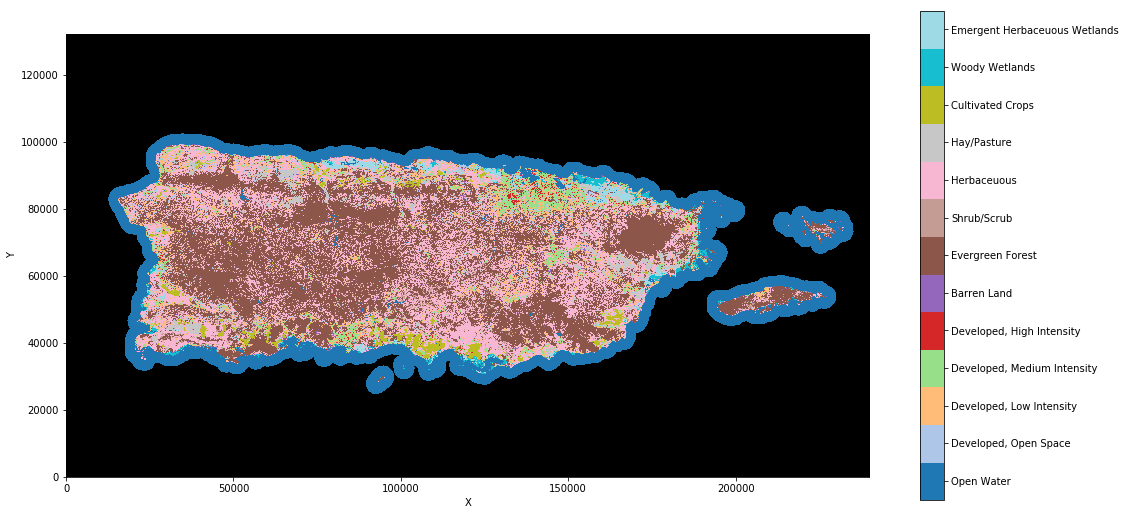

In [97]:
%%time
# somewhat slow step

# set colormap for n-categories
cmap = plt.cm.get_cmap('tab20', len(lcnldc['LAND_COVER']))

fig1, ax1 = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(nlcd, "topographic__elevation", cmap=cmap, allow_colorbar=False)

# label the colobar
cbar=plt.colorbar()
plt.clim(0,len(lcnldc['LAND_COVER'])) ## somehow "Emergent Herbaceuous Wetlands" is not shown, needed clim function
cbar.set_ticks(lcnldc['newvaluecode']+0.5)
cbar.set_ticklabels(lcnldc['LAND_COVER'])

CPU times: user 766 ms, sys: 4.19 ms, total: 770 ms
Wall time: 760 ms


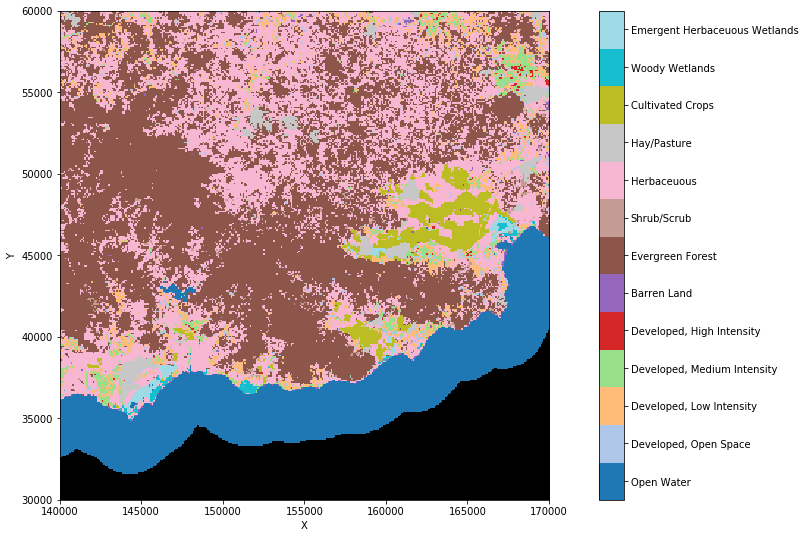

In [98]:
%%time
# somewhat slow step

# set colormap for n-categories
cmap = plt.cm.get_cmap('tab20', len(lcnldc['LAND_COVER']))

fig1, ax1 = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(nlcd, "topographic__elevation", cmap=cmap, allow_colorbar=False)

# label the colobar
cbar=plt.colorbar()
plt.clim(0,len(lcnldc['LAND_COVER'])) ## somehow "Emergent Herbaceuous Wetlands" is not shown, needed clim function
cbar.set_ticks(lcnldc['newvaluecode']+0.5)
cbar.set_ticklabels(lcnldc['LAND_COVER'])

# subset to view the Southeast PR region
fig1.gca().set_ylim([30000, 60000])
fig1.gca().set_xlim([140000, 170000])

In [163]:
""" Generate objects to maintain color coordination"""
# generate color order
col_order = list(cross_tab.index)
orig_order = list(lcnldc['LAND_COVER'])
new_order = [cmap_order.index(each) for each in col_order]
palette_dict = {each:cmap.colors[cmap_order.index(each)] for each in col_order}

In [99]:
%%time
# inspect pr_demfil_90.asc

pr_demfil, z2 = landlab.io.read_esri_ascii(os.path.join(hs7c32,'pr_demfil_90.asc'), name='topographic__elevation')

ocean = pr_demfil.at_node["topographic__elevation"] < 0.
pr_demfil.at_node["topographic__elevation"][ocean] = -999.
pr_demfil.set_nodata_nodes_to_closed(z2, nodata_value=-999.)


CPU times: user 52.7 s, sys: 976 ms, total: 53.7 s
Wall time: 53.7 s


CPU times: user 731 ms, sys: 56.3 ms, total: 787 ms
Wall time: 767 ms


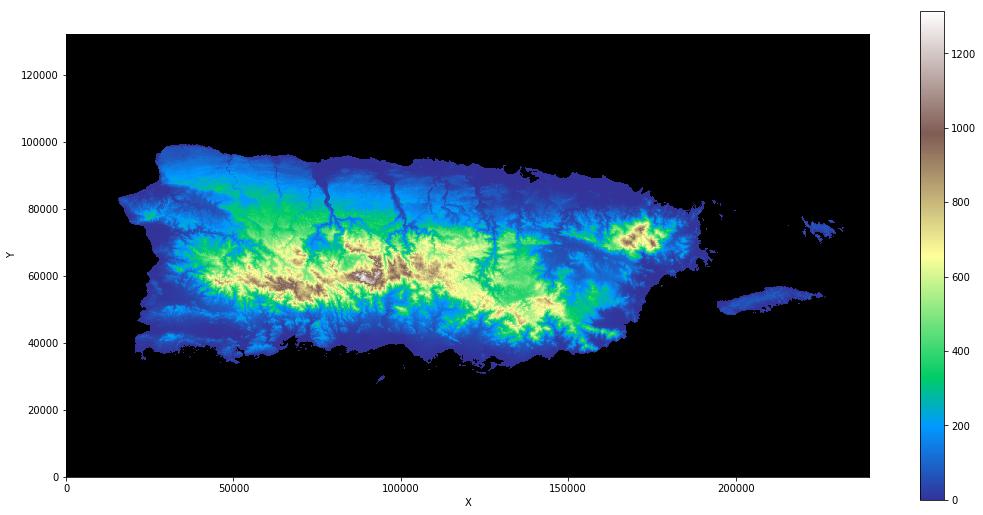

In [100]:
%%time
# somewhat slow step

fig2, ax2 = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(pr_demfil, "topographic__elevation", cmap="terrain")

In [ ]:
%%time
# crosstabulate the land_cover types by their gridcell elevation

landscape = pd.DataFrame({'landcover':z1,'elevation':z2})

# remove closed nodes
landscape = landscape[landscape['elevation']!=-999.]

# merge in landcover information
landscape = landscape.merge(lcnldc, how='left', left_on='landcover', right_on='newvaluecode')

# summarize elevation for each landcover
cross_tab = landscape.groupby('LAND_COVER')['elevation'].describe().sort_values('count', ascending=False)

In [ ]:
# ordered by abundance
cross_tab.index

In [ ]:
cross_tab.index[[list(lcnldc['LAND_COVER']).index(each) for each in list(cross_tab.index)]]

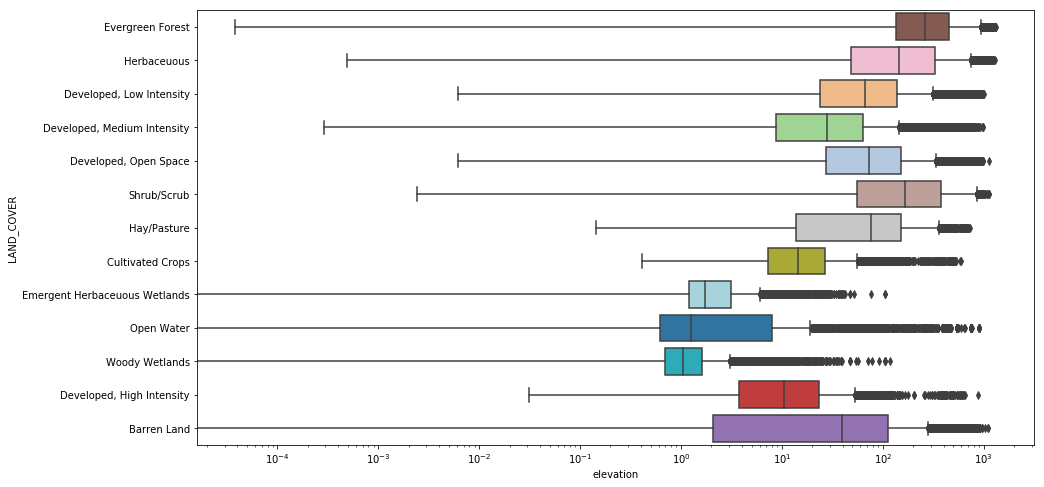

In [164]:
# generate plot dimensoons
fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

# horizontal boxplot elevation for each landcover categories
ax3 = sns.boxplot(data=landscape, x='elevation', y='LAND_COVER', orient='h',
                  order=cross_tab.index,
                  palette=cmap.colors[new_order])

# renormalize to decompress boxplots
ax3.set_xscale('log')

In [57]:
%%time
# inspect patillas_watersheds

watersheds, z3 = landlab.io.read_esri_ascii(os.path.join(hs7c32,'patillas_watersheds_90.asc'),
                                            name='topographic__elevation')

ocean = watersheds.at_node["topographic__elevation"] < 0.
watersheds.at_node["topographic__elevation"][ocean] = -999.
watersheds.set_nodata_nodes_to_closed(z3, nodata_value=-999.)
watersheds

CPU times: user 49.2 s, sys: 2.7 s, total: 51.9 s
Wall time: 51.8 s


CPU times: user 715 ms, sys: 136 ms, total: 851 ms
Wall time: 840 ms


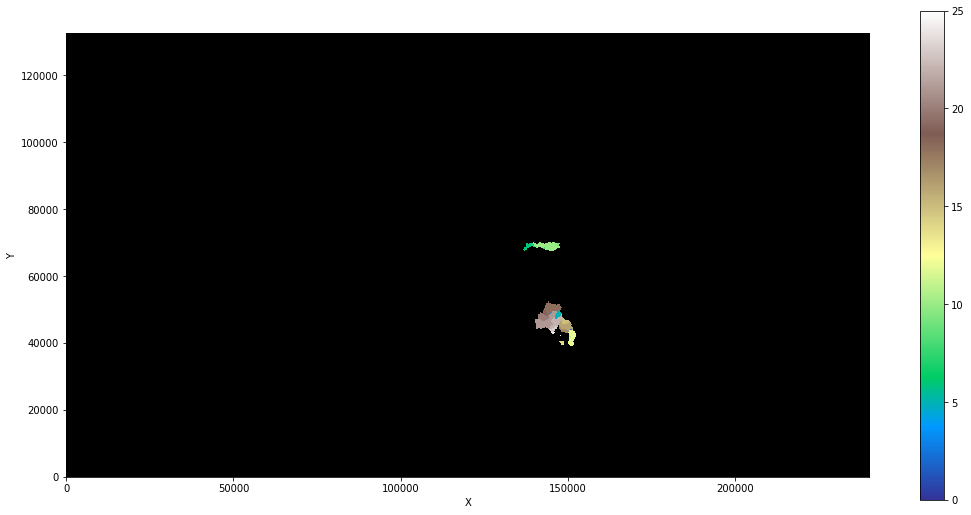

In [58]:
%%time
# somewhat slow step

fig4, ax4 = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(watersheds, "topographic__elevation", cmap="terrain")

In [61]:
# take a descriptive summary of the watersheds
# grouped by the series unique values
pd.Series(z3).astype('str').groupby(z3).describe(include='all').reset_index().rename(columns={'index':'landcover_types'})

,landcover_types,count,unique,top,freq
0,-999.0,3916339,1,-999.0,3916339
1,0.0,14,1,0.0,14
2,1.0,1,1,1.0,1
3,2.0,20,1,2.0,20
4,3.0,31,1,3.0,31
5,4.0,3,1,4.0,3
6,5.0,346,1,5.0,346
7,6.0,362,1,6.0,362
8,7.0,111,1,7.0,111
9,8.0,37,1,8.0,37


In [62]:
len(z1), len(z2), len(z3)

(3923157, 3923157, 3927296)

In [63]:
#watersheds seems to be 1x and 1y dimension larger
nlcd.shape, pr_demfil.shape, watersheds.shape

((1471, 2667), (1471, 2667), (1472, 2668))

In [64]:
# watersheds has an extra 90m
nlcd.grid_xdimension, pr_demfil.grid_xdimension, watersheds.grid_xdimension

(239940.0, 239940.0, 240030.0)

In [165]:
"""assuming the max x and y dimensions were added in error and closed anyways"""
#watersheds2 = copy.deepcopy(watersheds)

# generate a raster with the correct dimensions
watershed3 = landlab.RasterModelGrid(nlcd.shape[0], nlcd.shape[1], dx=90)
print(watershed3.shape)

(1471, 2667)


In [166]:
# identify the vector indices that are associated with mistake max x and y

x_to_remove = watersheds.x_of_node == watersheds.grid_xdimension
y_to_remove = watersheds.y_of_node == watersheds.grid_ydimension
positions_to_remove = x_to_remove + y_to_remove

# new vector
z4 = z3[~positions_to_remove]

# new rastermodelgrid
watershed3.at_node = {'topographic__elevation':z4}

# rastermodelgrid dimensions
watershed3.at_node['topographic__elevation'].shape

(3923157,)

In [167]:
#%%time
# crosstabulate the land_cover types by their gridcell elevation

# compile vector table
landscape_ct = pd.DataFrame({'landcover':z1,'elevation':z2, 'watersheds':z4})

# remove closed nodes
landscape_ct = landscape_ct[landscape_ct['watersheds']!=-999.]

# merge in landcover information
landscape_ct = landscape_ct.merge(lcnldc, how='left', left_on='landcover', right_on='newvaluecode')
landscape_ct['gridcell_unit'] = 1
landscape_ct['gridcell_area'] = 90*90

# elevation range per watershed
watershed_lc_elevation_stats = landscape_ct.groupby(['watersheds','LAND_COVER'])['elevation'].describe().reset_index()
watershed_lc_elevation_stats

,watersheds,LAND_COVER,count,mean,std,min,25%,50%,75%,max
0,0.0,Evergreen Forest,14.0,471.036214,36.245296,422.93440,440.435650,462.664100,505.606225,530.23770
1,1.0,Evergreen Forest,1.0,401.687200,NaN,401.68720,401.687200,401.687200,401.687200,401.68720
2,2.0,Evergreen Forest,20.0,446.675150,34.048159,388.09250,423.679375,448.160900,465.383250,510.29150
3,3.0,Evergreen Forest,31.0,514.913468,56.948748,364.65520,483.517200,530.070200,553.147250,594.83580
4,4.0,Evergreen Forest,3.0,313.759833,55.615378,250.31910,293.583250,336.847400,345.480200,354.11300
5,5.0,Evergreen Forest,346.0,553.248332,118.100974,270.21350,466.652950,576.580450,644.961700,751.57200
6,6.0,Barren Land,1.0,253.484400,NaN,253.48440,253.484400,253.484400,253.484400,253.48440
7,6.0,"Developed, High Intensity",2.0,285.543450,45.662622,253.25510,269.399275,285.543450,301.687625,317.83180
8,6.0,"Developed, Low Intensity",70.0,313.656459,55.166275,241.73550,272.904550,304.630000,317.824100,434.97730
9,6.0,"Developed, Medium Intensity",19.0,275.068558,21.391641,241.73550,260.987550,271.360800,284.177350,311.74480


In [190]:
landscape_ct

,elevation,landcover,watersheds,Rowid_,VALUE,RED,GREEN,BLUE,OPACITY,COUNT,LAND_COVER,newvaluecode,gridcell_unit,gridcell_area
0,166.375500,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
1,171.587600,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
2,163.614600,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
3,176.114500,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
4,203.086900,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
5,225.883400,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
6,180.590000,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
7,156.857000,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
8,151.630500,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
9,145.989200,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100


In [134]:
# %%time
# # somewhat slow step
# fig5, ax5 = plt.subplots(figsize=(18, 9))
# landscape.hist(column='watersheds', by='LAND_COVER', ax=ax5, bins=26)
# plt.set_xticks(np.array(range(0,25))+0.5)
# plt.set_xticklabels(np.array(range(0,25)))

The following chunk calculates the fractional presence of each landcover type for each watershed.

The resulting number is the probability of that landcover being affected within that watershed

So, if watershed 2 has a p(x) =1 for Evergreen forest, and we know that 20 percent of the area in watershed 1 (total area 1000 m^2) was affected, there is a 100% probability that Evergreen forest was affected. This yields an expected value that the 200 m^2 affected were Evergreen forest, 0 m^2 for all other categories.



In [191]:
# cross_tabulate the grid cell units
watershed_landcover = landscape_ct.pivot_table(columns='LAND_COVER', 
                                               index='watersheds',
                                               values='gridcell_unit',
                                               aggfunc=sum, margins=True)

# compute the landcover fractions for each watershed
fractions = watershed_landcover.apply(lambda x: x/x['All'], axis=1).fillna(0).drop('All').drop('All', axis=1)
fractions

LAND_COVER,Barren Land,Cultivated Crops,"Developed, High Intensity","Developed, Low Intensity","Developed, Medium Intensity","Developed, Open Space",Evergreen Forest,Hay/Pasture,Herbaceuous,Open Water,Shrub/Scrub
watersheds,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
6.0,0.002762,0.000000,0.005525,0.193370,0.052486,0.060773,0.419890,0.000000,0.265193,0.000000,0.000000
7.0,0.000000,0.000000,0.000000,0.171171,0.000000,0.027027,0.576577,0.000000,0.225225,0.000000,0.000000
8.0,0.000000,0.000000,0.000000,0.675676,0.000000,0.135135,0.081081,0.054054,0.054054,0.000000,0.000000


Text(0.5,0,'watershed landcover fraction')

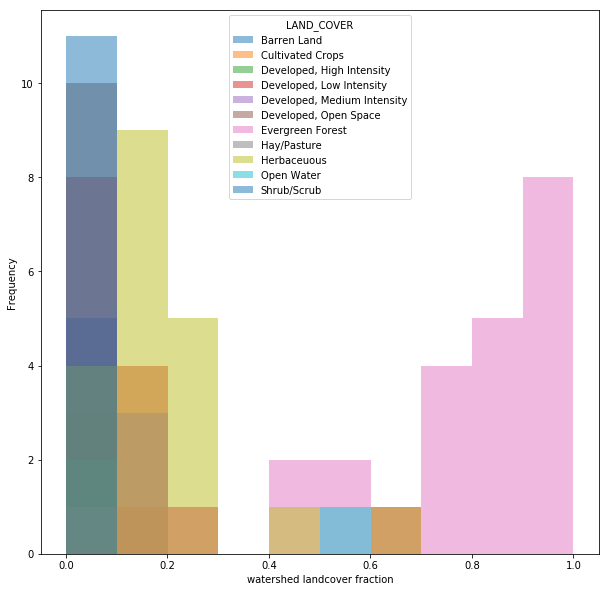

In [257]:
# cross_tabulate the grid cell units
watershed_landcover = landscape_ct.pivot_table(columns='LAND_COVER', 
                                               index='watersheds',
                                               values='gridcell_area',
                                               aggfunc=sum, margins=True)

# compute the landcover fractions for each watershed
fractions = watershed_landcover.apply(lambda x: x/x['All'], axis=1).drop('All').drop('All', axis=1)

# colorbar order in fractional presence
c_order = fractions.sum(axis=0).sort_values(ascending=False).index

fig8, ax8 = plt.subplots(figsize=(18, 15))
fractions.plot(kind='hist', bins=10, figsize=(10,10), ax=ax8, alpha=0.5).set_xlabel('watershed landcover fraction')

In [263]:
landscape_ct.groupby(['watersheds','LAND_COVER'])['gridcell_area'].sum()

,elevation,landcover,watersheds,Rowid_,VALUE,RED,GREEN,BLUE,OPACITY,COUNT,LAND_COVER,newvaluecode,gridcell_unit,gridcell_area
0,166.375500,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
1,171.587600,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
2,163.614600,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
3,176.114500,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
4,203.086900,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
5,225.883400,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
6,180.590000,6.0,12.0,NaN,42,0.11,0.39,0.19,1.0,5001858,Evergreen Forest,6.0,1,8100
7,156.857000,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
8,151.630500,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100
9,145.989200,8.0,12.0,NaN,71,0.89,0.89,0.76,1.0,3121076,Herbaceuous,8.0,1,8100


In [71]:
cross_tab.index

Index(['Evergreen Forest', 'Herbaceuous', 'Developed, Low Intensity',
       'Developed, Medium Intensity', 'Developed, Open Space', 'Shrub/Scrub',
       'Hay/Pasture', 'Cultivated Crops', 'Emergent Herbaceuous Wetlands',
       'Open Water', 'Woody Wetlands', 'Developed, High Intensity',
       'Barren Land'],
      dtype='object', name='LAND_COVER')

In [170]:
palette_dict

{'Evergreen Forest': array([ 0.54901961,  0.3372549 ,  0.29411765,  1.        ]),
 'Herbaceuous': array([ 0.96862745,  0.71372549,  0.82352941,  1.        ]),
 'Developed, Low Intensity': array([ 1.        ,  0.73333333,  0.47058824,  1.        ]),
 'Developed, Medium Intensity': array([ 0.59607843,  0.8745098 ,  0.54117647,  1.        ]),
 'Developed, Open Space': array([ 0.68235294,  0.78039216,  0.90980392,  1.        ]),
 'Shrub/Scrub': array([ 0.76862745,  0.61176471,  0.58039216,  1.        ]),
 'Hay/Pasture': array([ 0.78039216,  0.78039216,  0.78039216,  1.        ]),
 'Cultivated Crops': array([ 0.7372549 ,  0.74117647,  0.13333333,  1.        ]),
 'Emergent Herbaceuous Wetlands': array([ 0.61960784,  0.85490196,  0.89803922,  1.        ]),
 'Open Water': array([ 0.12156863,  0.46666667,  0.70588235,  1.        ]),
 'Woody Wetlands': array([ 0.09019608,  0.74509804,  0.81176471,  1.        ]),
 'Developed, High Intensity': array([ 0.83921569,  0.15294118,  0.15686275,  1.     

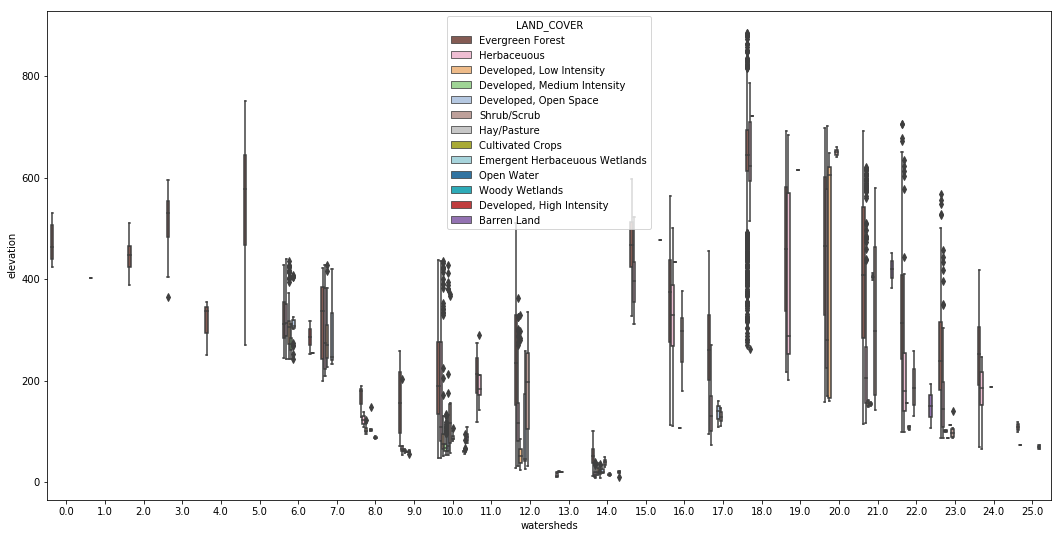

In [181]:
fig5, ax5 = plt.subplots(figsize=(18, 9))

g = sns.boxplot(data=landscape_ct, hue='LAND_COVER', x='watersheds', y='elevation', 
                palette=palette_dict, hue_order=col_order)
#plt.legend(loc=2)

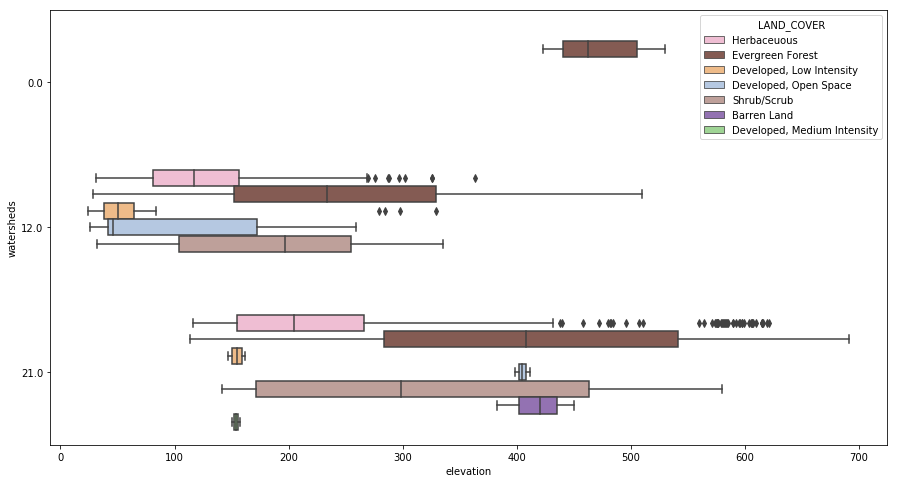

In [188]:
""" Let's compare a few of the watersheds according to their elevation per landcover category"""
watershed_ids = [0,12,21]

extracted_watersheds = landscape_ct[landscape_ct.watersheds.isin(watershed_ids)]

fig5, ax5 = plt.subplots(figsize=(15, 8))

g = sns.boxplot(data=extracted_watersheds, hue="LAND_COVER", x="elevation", y="watersheds",
                palette=palette_dict, orient='h')

CPU times: user 1min 51s, sys: 7.01 s, total: 1min 58s
Wall time: 1min 58s


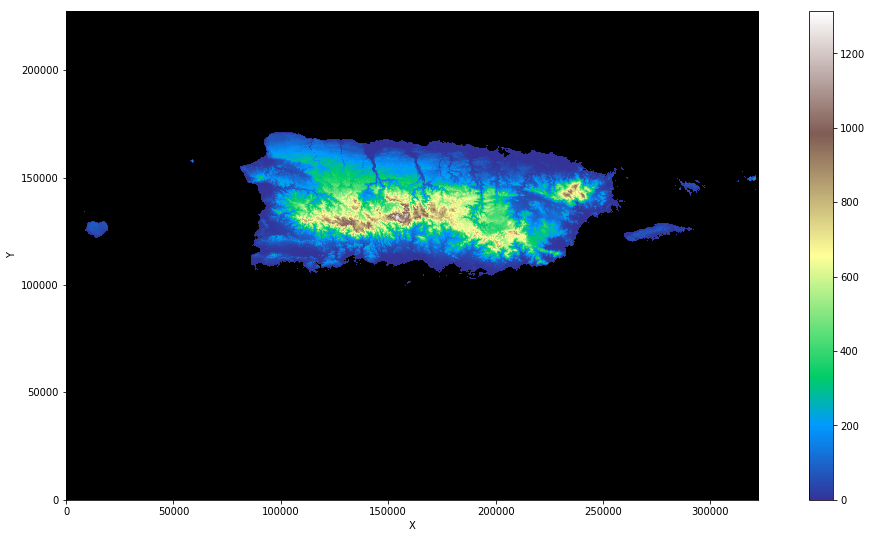

In [133]:
%%time
"""Visualize the dem that Eric worked with"""
# inspect puertorico_dem90fil

puertorico_dem90fil, z6 = landlab.io.read_esri_ascii(os.path.join(hs7c32,'puertorico_dem90fil.asc'), name='topographic__elevation')

ocean = puertorico_dem90fil.at_node["topographic__elevation"] < 0.
puertorico_dem90fil.at_node["topographic__elevation"][ocean] = -999.
puertorico_dem90fil.set_nodata_nodes_to_closed(z6, nodata_value=-999.)

fig7, ax7 = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(puertorico_dem90fil, "topographic__elevation", cmap="terrain")


In [ ]:
PR_c = gpd.read_file(os.path.join(hs7c32,'county_PR_census2010_reduced.shp'))
PR_c

Find Patillas

In [ ]:
Patillas = PR_c.loc[PR_c['NAMELSAD10'].apply(lambda x: x.startswith('Pa'))]
Patillas.plot()

Find the neighboring municipios to Patillas

In [ ]:
Patillas_2 = gpd.sjoin(left_df=PR_c, right_df=Patillas[['geometry']], 
                       how='inner', op='intersects').reset_index(drop=True)
Patillas_2.plot(column='Total_pop_', edgecolor='gray', legend=True)

Convert from Geographic to raster dimensions

In [ ]:
Patillas_2['geometry'] = Patillas_2['geometry'].to_crs(proj.srs)

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18, 9))

# plot the municipio regions
#Patillas_2.plot(column='Total_pop_', edgecolor='gray', legend=True, ax=ax1, alpha=0.5, zorder=0)
Patillas_2.plot(column='Total_pop_', edgecolor='gray', legend=True, ax=ax1, alpha=0.5, zorder=1000000000)

# plot the topography
#landlab.plot.imshow_grid(nldc, "topographic__elevation", cmap=cmap)



# subset to view the Southeast PR region
#fig1.gca().set_ylim([30000, 60000])
#fig1.gca().set_xlim([140000, 220000])


In [ ]:
fig1, ax1 = plt.subplots(figsize=(18, 9))
PR_c.plot(column='Total_pop_', edgecolor='gray', legend=True, ax=ax1, alpha=0.5, zorder=1000000000)

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(nldc, "topographic__elevation", cmap=cmap)

In [ ]:
test = Patillas_2['geometry'].apply(lambda x: proj(tuple(x)))

In [ ]:
# for x,y in zip(np.array(Patillas_2['geometry'][0])):
#     a,b = proj(x,y)
#     print(a,b)

Patillas_2['geometry'][0]#.apply(lambda x: float(x))

In [ ]:
with open(os.path.join(hs7c32,'pr_demfil_90.prj'), 'r') as file1:
    for eachline in file1:
        print(eachline)

In [ ]:
tmp = pd.read_table(os.path.join(hs7c32,'pr_demfil_90.prj'), sep='\s+',header=None)
tmp

In [ ]:
#tmp.set_index([0])
#tmp.apply(lambda x: {x[0]:x[1]}, axis=1)
help(tmp.to_dict)